VGG16UNET은 결과가 잘 뽑혔습니다.
Encoder-Decoder 모델과 ResNet 모델은 에포크가 적어서 그런지 결과가 나오지 않았습니다. 시간이 있다면 좀 더 수정해보고 싶었습니다.
예상되는 원인으로는 1. 데이터 증강을 좀 더 해야 하거나 2. 에포크를 늘려보던가.
과적합이 너무 빨리 실현되는 것 같습니다.

In [22]:
import tensorflow as tf
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [23]:
# 데이터 경로 설정
data_path = "./train"  # BMP 이미지가 있는 경로
label_path = "./train_label"  # 라벨 이미지가 있는 경로

# 이미지 및 라벨 불러오기
def load_bmp_images_and_labels(data_path, label_path):
    image_files = sorted([os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('.bmp')])
    label_files = sorted([os.path.join(label_path, file) for file in os.listdir(label_path) if file.endswith('.bmp')])
    images = [tf.image.decode_bmp(tf.io.read_file(file)) for file in image_files]
    labels = [tf.image.decode_bmp(tf.io.read_file(file)) for file in label_files]
    return images, labels

images, labels = load_bmp_images_and_labels(data_path, label_path)

# 데이터 크기와 데이터 유형 설정
def preprocess_image_and_label(image, label, target_size=(256, 256)):
    image = tf.image.resize(image, target_size)
    label = tf.image.resize(label, target_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    label = tf.cast(label > 0.5, tf.uint8)  # Thresholding to binary labels
    return image, label

# 데이터 증강 함수
def augment_image_and_label(image, label):
    if random.random() > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    if random.random() > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)
    if random.random() > 0.5:
        image = tf.image.rot90(image)
        label = tf.image.rot90(label)
    return image, label

# 데이터셋 생성
def create_dataset(images, labels, batch_size=16, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: preprocess_image_and_label(x, y))
    if augment:
        dataset = dataset.map(lambda x, y: augment_image_and_label(x, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [24]:
#label 데이터 확인
for img, lbl in train_dataset.take(1):
    print("Unique values in label:", tf.unique(tf.reshape(lbl, [-1])).y.numpy())

Unique values in label: [  0  49   2  53 159 255 190  41  29 252   6  17   5 246 214  32 243  72
 225 213 142 201 197  37 189 192 165 162 151  69 141 198 113 131 147  62
  23  30  61   4 166  66  39 228  18 233  88 156 152 220  28   3 178 247
 150 160  98 161  80 168 106  19 170  91  44  85 235  89  35  52  10 126
  33 248 205 177   1 250   9 221   7 232  40 211 153 163 191 206 115 187
  22 164  48 101 234 242 148  14 109 132  59 130 140 251  82 181 216 137
  96 149  27 173  26  74 185 127 209 241 249 245 169 215  60 219  56 217
  76  65 188 199  84  20  93   8 146 121 136 138 254 183 240  87 145 207
  55 144 186 155 174 218 139 203 236 253 104 223  67 117 105  25  86 196
  57 224 202 175  31 226 212 118  64  11 193 128  77 116 237  78 134  45
 125  46 239  13  90  21 204 227 157 124 154 167  70  71 231  16 210 238
 230  42  51  94 200 208  24 244 114 184 129 119  73 222  54 102  38  15
 172 122  50 176  43  99 120 100  79  97 133 110  83 195  92 107  95  63
 229 112  36  12  58 171 11

In [25]:
# 데이터셋 분할
split_ratio = 0.8
split_index = int(len(images) * split_ratio)
train_images, test_images = images[:split_index], images[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# 학습 및 테스트 데이터셋 생성
train_dataset = create_dataset(train_images, train_labels, batch_size=16, augment=True)
test_dataset = create_dataset(test_images, test_labels, batch_size=16, shuffle=False, augment=False)

# 데이터셋 확인
for img_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", label_batch.shape)

Image batch shape: (16, 256, 256, 3)
Label batch shape: (16, 256, 256, 1)


In [26]:
# VGG16의 입력 크기를 설정 (256x256x3)
img_shape = (256, 256, 3)

# VGG16 모델 생성
vgg16 = tf.keras.applications.VGG16(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet'
)

# 레이어 출력 확인
layer_outputs = [layer.output for layer in vgg16.layers]
print(layer_outputs)

[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_151>, <KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_152>, <KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_153>, <KerasTensor shape=(None, 128, 128, 64), dtype=float32, sparse=False, name=keras_tensor_154>, <KerasTensor shape=(None, 128, 128, 128), dtype=float32, sparse=False, name=keras_tensor_155>, <KerasTensor shape=(None, 128, 128, 128), dtype=float32, sparse=False, name=keras_tensor_156>, <KerasTensor shape=(None, 64, 64, 128), dtype=float32, sparse=False, name=keras_tensor_157>, <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_158>, <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_159>, <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_160>, <KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=

In [27]:
# ConvBlock 및 DecoderBlock 정의 포함
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")
        self.conv2 = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")
        self.batchnorm = layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.batchnorm(x, training=training)
        x = self.conv2(x)
        return x

class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.upconv = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")
        self.convblock = ConvBlock(filters)

    def call(self, inputs, skip_connection, training=False):
        x = self.upconv(inputs)
        x = tf.concat([x, skip_connection], axis=-1)  # Skip connection
        x = self.convblock(x, training=training)
        return x

# Vgg16UNet 정의
class Vgg16UNet(tf.keras.Model):
    def __init__(self, img_shape):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                                 include_top=False,
                                                 weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs
    
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + 1e-7) / (union + 1e-7)

In [28]:
#데이터 범위 확인
for img, lbl in train_dataset.take(1):
    print("Image shape:", img.shape)
    print("Label shape:", lbl.shape)
    print("Label dtype:", lbl.dtype)
    print("Label unique values:", tf.unique(tf.reshape(lbl, [-1])).y.numpy())

Image shape: (16, 256, 256, 3)
Label shape: (16, 256, 256, 1)
Label dtype: <dtype: 'uint8'>
Label unique values: [0 1]


Epoch 1/20


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vgg16u_net_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 357s 23s/step - accuracy: 0.6458 - dice_coefficient: 0.0634 - loss: 0.6456 - val_accuracy: 0.8984 - val_dice_coefficient: 7.4369e-04 - val_loss: 0.3550
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 350s 23s/step - accuracy: 0.9356 - dice_coefficient: 0.0300 - loss: 0.3172 - val_accuracy: 0.9542 - val_dice_coefficient: 1.1886e-04 - val_loss: 0.2769
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 351s 24s/step - accuracy: 0.9423 - dice_coefficient: 0.0082 - loss: 0.2305 - val_accuracy: 0.9441 - val_dice_coefficient: 0.0848 - val_loss: 0.2933
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 350s 23s/step - accuracy: 0.9512 - dice_coefficient: 0.3827 - loss: 0.1635 - val_accuracy: 0.9625 - val_dice_coefficient: 0.0039 - val_loss: 0.2470
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 353s 24s/step - accuracy: 0.9702 - dice_coefficient: 0.6926 - loss: 0.1038 - val_accuracy: 0.9329 - val_dice_coefficient: 0.1928 - val_loss: 0.2647
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 352s 24s/step - accuracy: 0.9801 - 

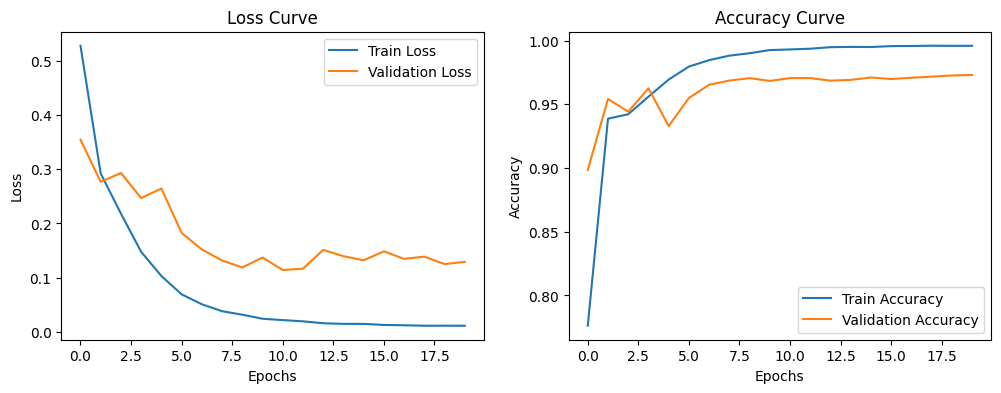

In [29]:
# 모델 생성
model = Vgg16UNet(img_shape)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", dice_coefficient])

# 모델 학습
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.9740 - dice_coefficient: 0.4547 - loss: 0.1189
Test Loss: 0.1289936602115631, Test Accuracy: 0.9729459285736084, MeanIoU: 0.3768237233161926
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


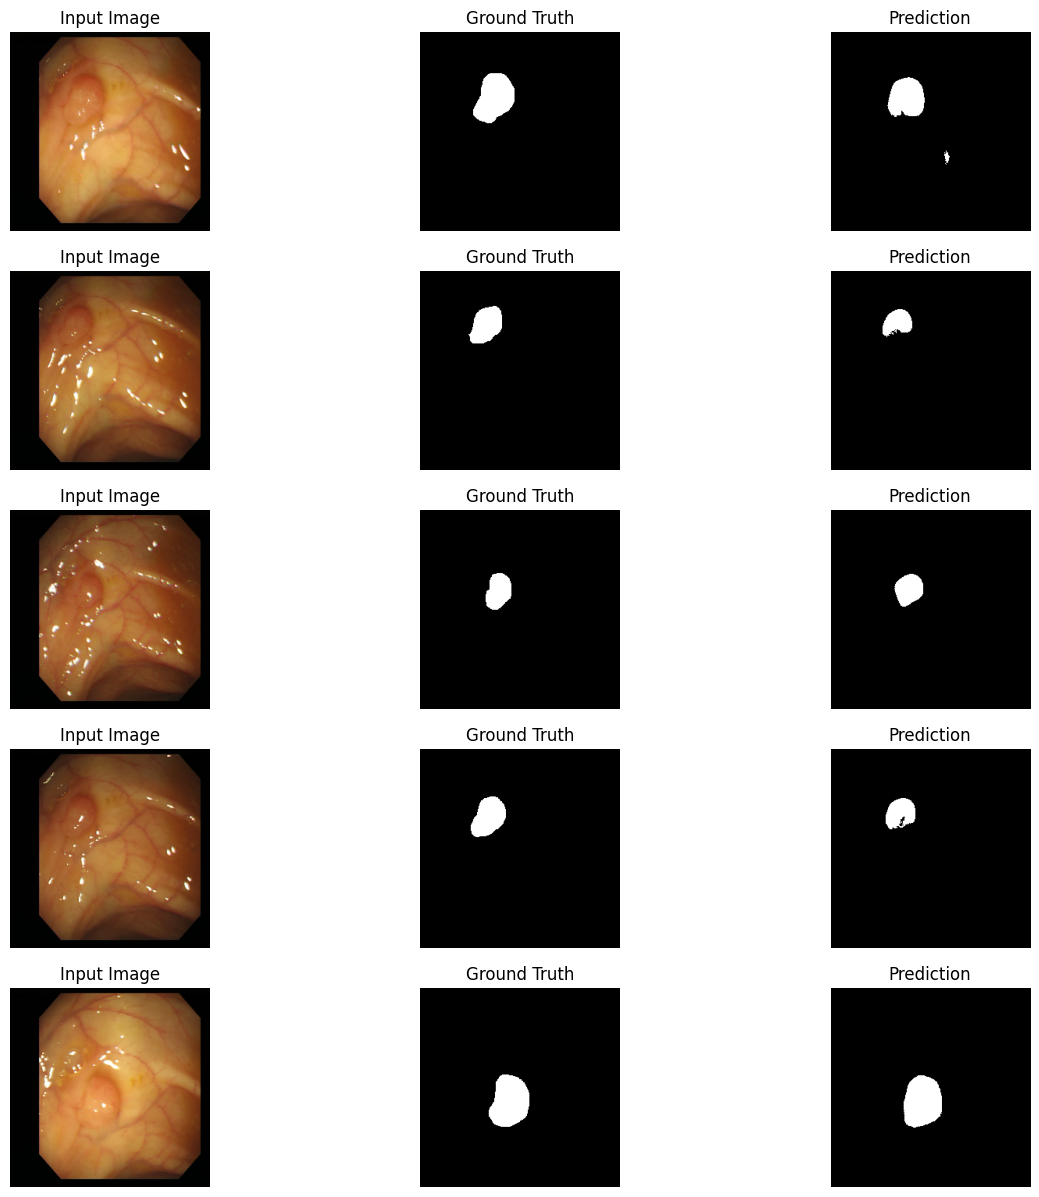

In [30]:
# 테스트 데이터 평가
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, MeanIoU: {results[2]}")

# 시각화 함수 정의
def visualize_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        pred = model.predict(tf.expand_dims(image, axis=0))
        pred = (pred[0, :, :, 0] > 0.5).astype(np.uint8)  # Thresholding

        # 입력 이미지
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.numpy())
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth 라벨
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(label.numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # 모델 예측 결과
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

# 테스트 데이터에서 시각화
visualize_predictions(model, test_dataset, num_samples=5)

In [31]:
# Encoder-Decoder 모델 정의
class EncoderDecoder(tf.keras.Model):
    def __init__(self, input_shape):
        super(EncoderDecoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')  # Binary segmentation
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

Epoch 1/20


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.9025 - loss: 0.6876 - mean_io_u_3: 0.4703 - val_accuracy: 0.9669 - val_loss: 0.6431 - val_mean_io_u_3: 0.4834
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.9418 - loss: 0.5985 - mean_io_u_3: 0.4709 - val_accuracy: 0.9669 - val_loss: 0.3238 - val_mean_io_u_3: 0.4834
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9396 - loss: 0.4175 - mean_io_u_3: 0.4698 - val_accuracy: 0.9669 - val_loss: 0.2668 - val_mean_io_u_3: 0.4834
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.9417 - loss: 0.3607 - mean_io_u_3: 0.4708 - val_accuracy: 0.9669 - val_loss: 0.2296 - val_mean_io_u_3: 0.4834
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.9415 - loss: 0.3264 - mean_io_u_3: 0.4708 - val_accuracy: 0.9669 - val_loss: 0.1962 - val_mean_io_u_3: 0.4834
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.9444 - loss: 0.2649 - mean_io_u_3: 0.4722 - val_accuracy: 0.9669 - val_loss: 

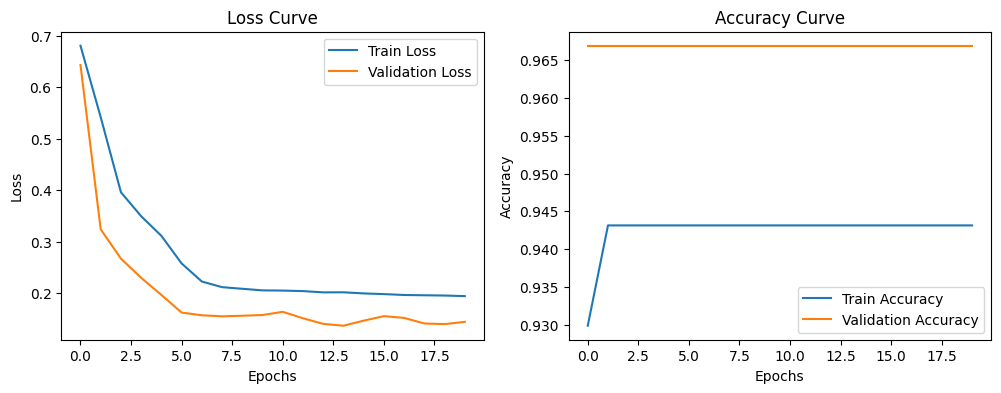

In [32]:
# 모델 생성
input_shape = (256, 256, 3)
model = EncoderDecoder(input_shape)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

# 학습
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step - accuracy: 0.9663 - loss: 0.1416 - mean_io_u_3: 0.4832
Test Loss: 0.14398083090782166, Test Accuracy: 0.9668866395950317, MeanIoU: 0.48344331979751587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


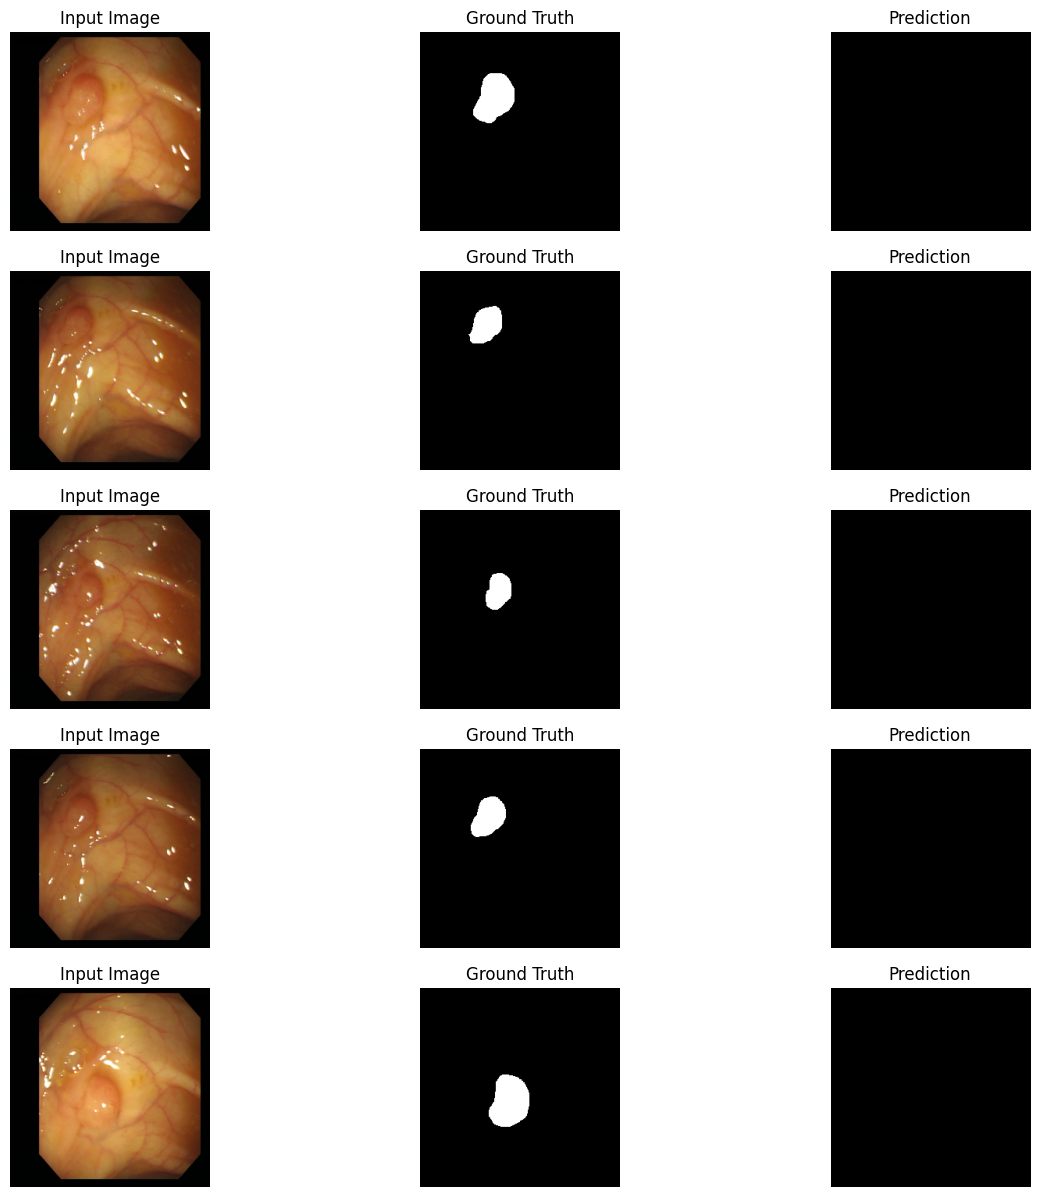

In [34]:
# 테스트 데이터 평가
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, MeanIoU: {results[2]}")

# 시각화 함수
def visualize_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        pred = model.predict(tf.expand_dims(image, axis=0))
        pred = (pred[0, :, :, 0] > 0.5).astype(np.uint8)  # Thresholding

        # 입력 이미지
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.numpy())
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth 라벨
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(label.numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # 모델 예측 결과
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

# 테스트 데이터 시각화
visualize_predictions(model, test_dataset, num_samples=5)

In [39]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.upconv = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")
        self.convblock = ConvBlock(filters)

    def call(self, inputs, skip_connection, training=False):
        x = self.upconv(inputs)
        x = tf.concat([x, skip_connection], axis=-1)  # Skip connection
        x = self.convblock(x, training=training)
        return x

# ResNet 기반 U-Net 모델 수정
class ResNetUNet(tf.keras.Model):
    def __init__(self, input_shape):
        super(ResNetUNet, self).__init__()
        
        # ResNet50 Encoder (사전 학습된 가중치 사용)
        base_model = tf.keras.applications.ResNet50(
            input_shape=input_shape, include_top=False, weights="imagenet"
        )
        self.encoder_layers = [
            base_model.get_layer("conv1_relu").output,  # Stage 1
            base_model.get_layer("conv2_block3_out").output,  # Stage 2
            base_model.get_layer("conv3_block4_out").output,  # Stage 3
            base_model.get_layer("conv4_block6_out").output,  # Stage 4
            base_model.get_layer("conv5_block3_out").output,  # Stage 5
        ]
        self.encoder = models.Model(inputs=base_model.input, outputs=self.encoder_layers)

        # Center block
        self.center = ConvBlock(2048)

        # Decoder blocks
        self.decoder_block4 = DecoderBlock(1024)
        self.decoder_block3 = DecoderBlock(512)
        self.decoder_block2 = DecoderBlock(256)
        self.decoder_block1 = DecoderBlock(64)

        # Output layer with resizing
        self.output_conv = layers.Conv2D(1, 1, activation="sigmoid")
        self.resize_output = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")  # 추가 업샘플링

    def call(self, inputs, training=True):
        # Encoder
        encoder1, encoder2, encoder3, encoder4, center = self.encoder(inputs)

        # Decoder with skip connections
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        # Output
        outputs = self.output_conv(decoder1)
        outputs = self.resize_output(outputs)  # 최종 출력 크기를 256x256으로 조정
        return outputs

Epoch 1/20


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'res_net_u_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 268s 16s/step - accuracy: 0.4508 - loss: 0.8349 - mean_io_u_5: 0.4712 - val_accuracy: 0.0331 - val_loss: 1.3661 - val_mean_io_u_5: 0.4834
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 240s 16s/step - accuracy: 0.9422 - loss: 0.3381 - mean_io_u_5: 0.4722 - val_accuracy: 0.0331 - val_loss: 2.1225 - val_mean_io_u_5: 0.4834
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 239s 16s/step - accuracy: 0.9824 - loss: 0.1414 - mean_io_u_5: 0.4721 - val_accuracy: 0.0331 - val_loss: 2.6565 - val_mean_io_u_5: 0.4834
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 236s 16s/step - accuracy: 0.9875 - loss: 0.0763 - mean_io_u_5: 0.4695 - val_accuracy: 0.0336 - val_loss: 1.7718 - val_mean_io_u_5: 0.4834
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 240s 16s/step - accuracy: 0.9901 - loss: 0.0497 - mean_io_u_5: 0.4712 - val_accuracy: 0.3778 - val_loss: 0.8786 - val_mean_io_u_5: 0.4834
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 237s 16s/step - accuracy: 0.9920 - loss: 0.0361 - mean_io_u_5: 0.4720 - val_accuracy: 0.8198 

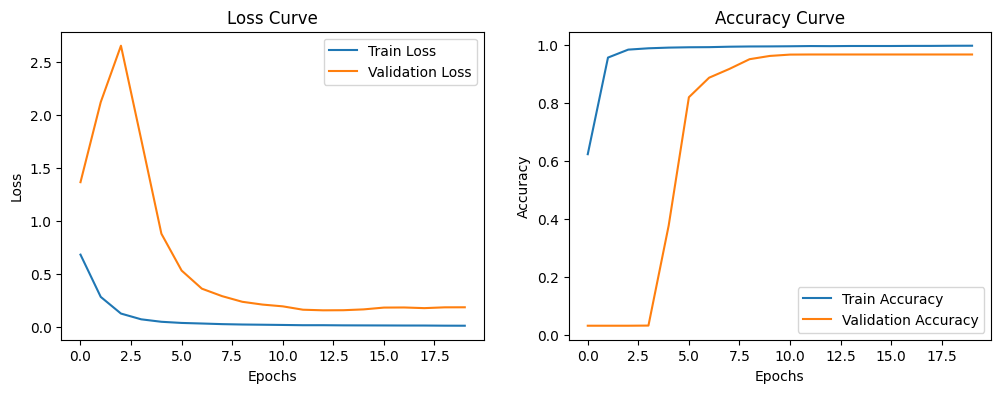

In [40]:
# 모델 생성
model = ResNetUNet(input_shape=(256, 256, 3))

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

# 학습
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# 테스트 데이터 평가
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, MeanIoU: {results[2]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9663 - loss: 0.1866 - mean_io_u_5: 0.4832
Test Loss: 0.18304568529129028, Test Accuracy: 0.9668866395950317, MeanIoU: 0.48344331979751587


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


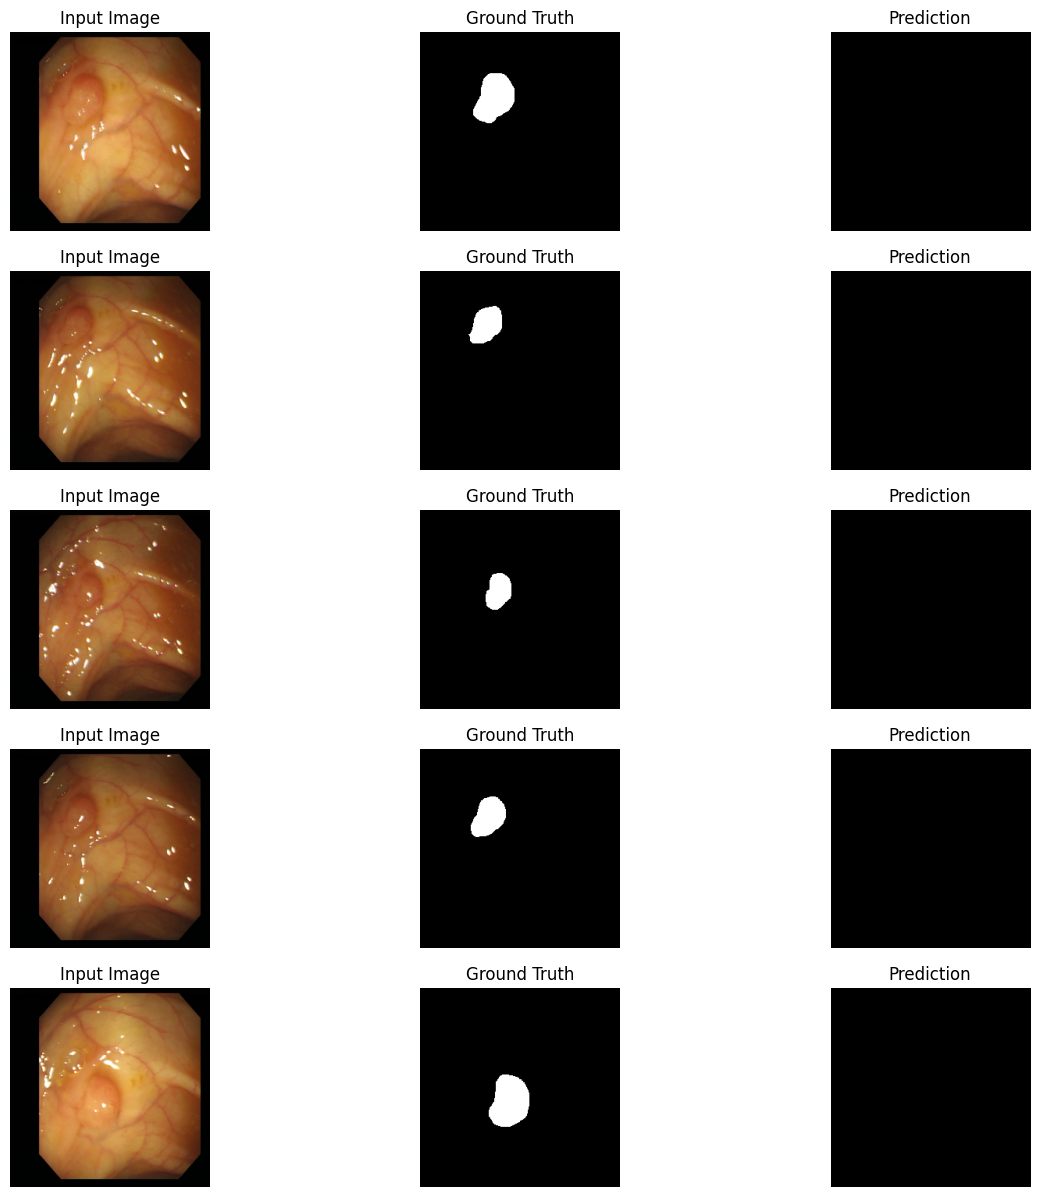

In [42]:
def visualize_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        pred = model.predict(tf.expand_dims(image, axis=0))
        pred = (pred[0, :, :, 0] > 0.5).astype(np.uint8)  # Thresholding

        # 입력 이미지
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.numpy())
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth 라벨
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(label.numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # 모델 예측 결과
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

# 테스트 데이터 시각화
visualize_predictions(model, test_dataset, num_samples=5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9663 - loss: 0.1866 - mean_io_u_5: 0.4832
Test Loss: 0.18304568529129028, Test Accuracy: 0.9668866395950317, MeanIoU: 0.48344331979751587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Prediction shape: (256, 256), unique values: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Prediction shape: (256, 256), unique values: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Prediction shape: (256, 256), unique values: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Prediction shape: (256, 256), unique values: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
Prediction shape: (256, 256), unique values: [0]


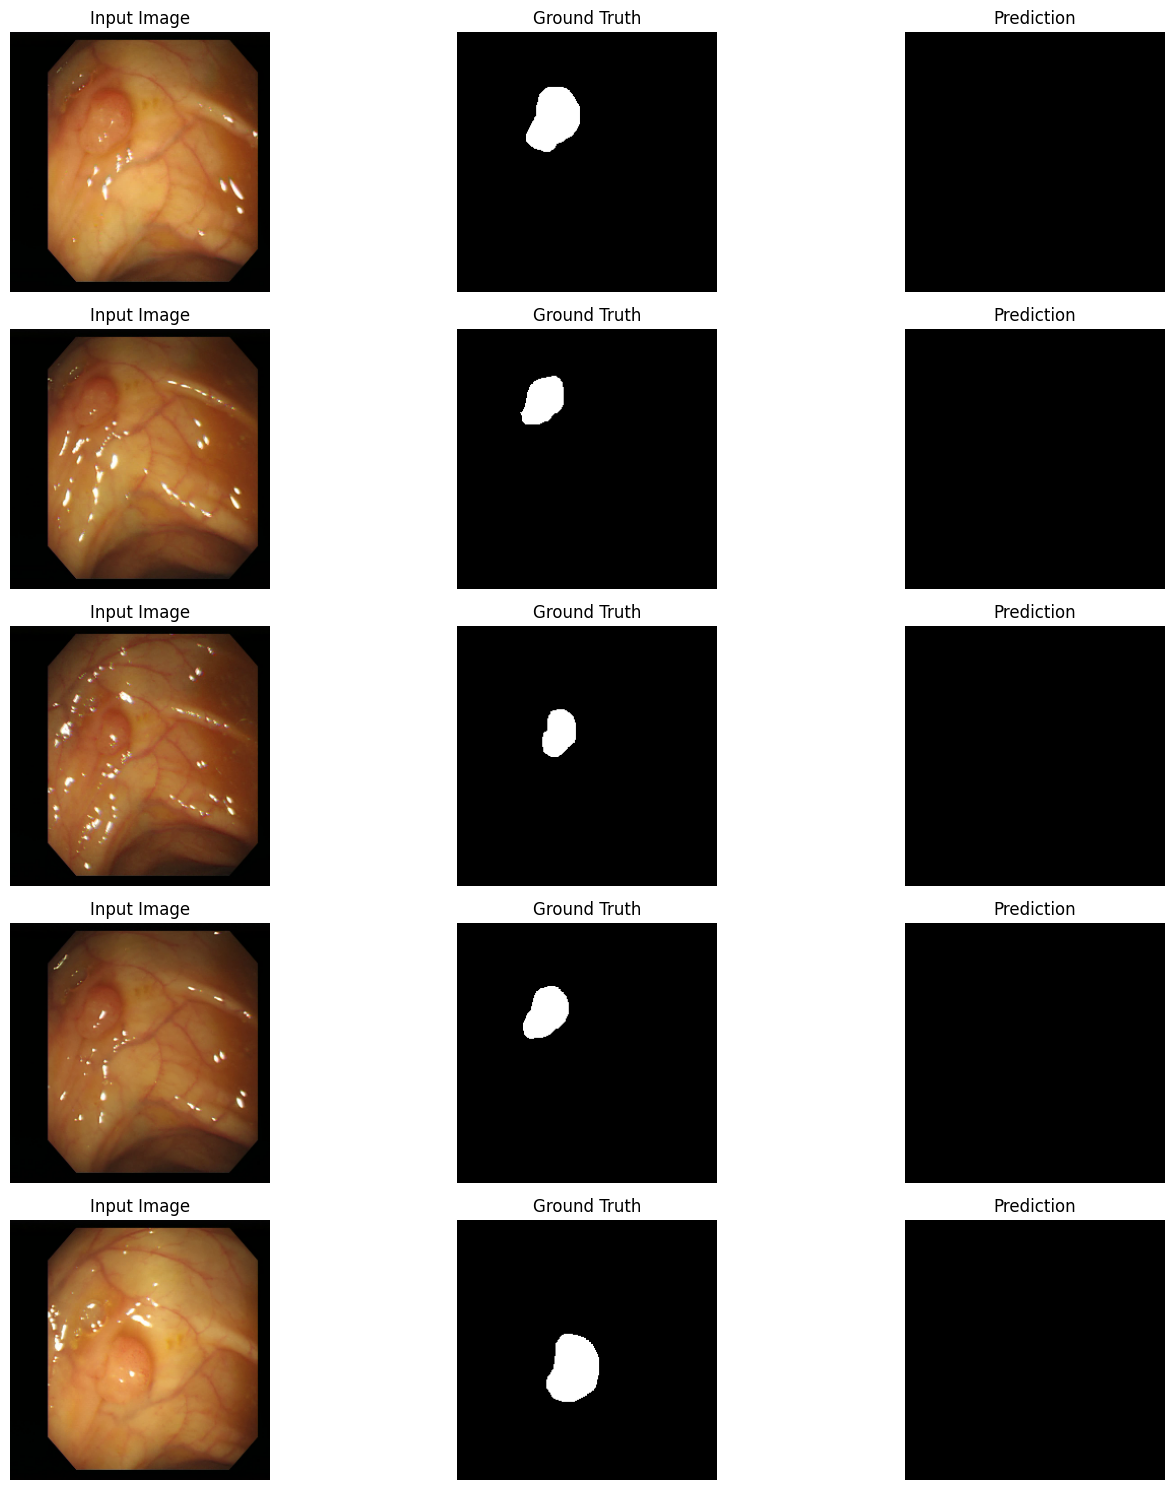

In [44]:
# 테스트 데이터 평가
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, MeanIoU: {results[2]}")

# 시각화 함수
def visualize_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        # 모델 예측
        pred = model.predict(tf.expand_dims(image, axis=0))
        pred = (pred[0, :, :, 0] > 0.5).astype(np.uint8)  # Thresholding for binary mask
        
        # 예측 결과 확인 (디버깅용)
        print(f"Prediction shape: {pred.shape}, unique values: {np.unique(pred)}")

        # 입력 이미지 시각화
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.numpy())
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth 라벨 시각화
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(label.numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # 모델 예측 결과 시각화
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 테스트 데이터에서 시각화
visualize_predictions(model, test_dataset, num_samples=5)
